# Comparing Decision Trees and Random Forest
Pick a dataset. It could be one you've worked with before or it could be a new dataset. Then build the best decision tree that you can.

Now, try to match that with the simplest random forest that you can. For this exercise, measure simplicity with [runtime](http://stackoverflow.com/questions/1557571/how-to-get-time-of-a-python-program-execution). Compare that to the runtime of the decision tree. This is imperfect, but just go with it.

Hopefully, out of this you'll see the power of random forests, but you'll also see their potential costs. Remember, in the real world, you won't necessarily be dealing with thousands of rows. There may be millions, billions, or even more.



First, I will import relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import ensemble # RandomForestClassifier()
from sklearn.preprocessing import OneHotEncoder

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Display preferences.
%matplotlib inline
sns.set()
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

I will also add timing information.

In [2]:
import time
from datetime import timedelta

## Decision Tree

For my test dataset, I will choose the [abalone data set](http://archive.ics.uci.edu/dataset/1/abalone) from the UCI Machine Learning Repository. The dataset is summarized below.

Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).


Data Dictionary:

* `Sex (Feature,Categorical)`: M, F, and I (infant)
* `Length (Feature,Continuous)`: Longest shell measurement
* `Diameter (Feature,Continuous)`: perpendicular to length
* `Height (Feature,Continuous)`: with meat in shell
* `Whole Weight (Feature,Continuous)`: whole abalone
* `Shucked Weight (Feature,Continuous)`: weight of meat
* `Viscera Weight (Feature,Continuous)`: gut weight (after bleeding)
* `Shell Weight (Feature,Continuous)`: after being dried
* `Rings (Target,Integer)`: +1.5 gives the age in years

The target variable is `Rings` and is used to measure the age in years. We won't do any data cleaning.


In [3]:
abalone_df = pd.read_csv('abalone.data',header=None,
                         names=['Sex','Length','Diameter','Height','Whole Weight','Shucked Weight',
                                'Viscera Weight','Shell Weight','Rings'])
abalone_df.describe(include='all')

Sex   Length  Diameter   Height  Whole Weight  Shucked Weight  \
count   4177 4177.000  4177.000 4177.000      4177.000        4177.000   
unique     3      NaN       NaN      NaN           NaN             NaN   
top        M      NaN       NaN      NaN           NaN             NaN   
freq    1528      NaN       NaN      NaN           NaN             NaN   
mean     NaN    0.524     0.408    0.140         0.829           0.359   
std      NaN    0.120     0.099    0.042         0.490           0.222   
min      NaN    0.075     0.055    0.000         0.002           0.001   
25%      NaN    0.450     0.350    0.115         0.442           0.186   
50%      NaN    0.545     0.425    0.140         0.799           0.336   
75%      NaN    0.615     0.480    0.165         1.153           0.502   
max      NaN    0.815     0.650    1.130         2.825           1.488   

        Viscera Weight  Shell Weight    Rings  
count         4177.000      4177.000 4177.000  
unique             NaN           NaN      NaN  
top                NaN           NaN      NaN  
freq               NaN           NaN      NaN  
mean             0.181         0.239    9.934  
std              0.110         0.139    3.224  
min              0.001         0.002    1.000  
25%              0.093         0.130    8.000  
50%              0.171         0.234    9.000  
75%              0.253         0.329   11.000  
max              0.760         1.005   29.000

To simplify the dataset, we will turn `Rings` which measures age into 4 bins.

In [4]:
target_labels = ['Baby','Adolescent','Adult','Old']
abalone_df['Age Range'] = pd.cut(abalone_df['Rings'],4,labels=target_labels)

In [5]:
abalone_df['Age Range'].value_counts()

Adolescent    2509
Baby          1407
Adult          245
Old             16
Name: Age Range, dtype: int64

<Axes: xlabel='Age Range', ylabel='count'>

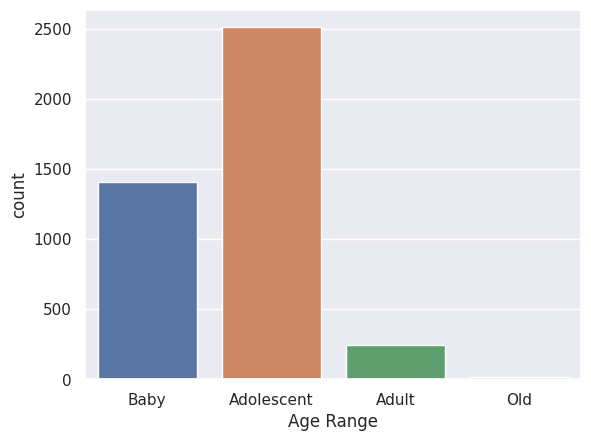

In [6]:
sns.countplot(x='Age Range',data=abalone_df)

Next, we convert categorical variable into dummy/indicator variables.

In [7]:
abalone_df.drop('Rings',axis='columns',inplace=True)
Y = abalone_df['Age Range']
X = abalone_df.drop('Age Range',axis='columns')
X = pd.get_dummies(X,drop_first=True)

To test we will measure these results against a Decision Tree classifier. For this task we will only compare runtime of the Random Forest classifier and Decision Tree classifier.

In the real world we could have millions, billions, or even trillions of records. So, optimizing performance would be crucial.


In [8]:
# Calculate time to create and train this decision tree
start_time = time.time()

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features='auto',
    #max_depth=8,
    random_state = 1337
)
decision_tree.fit(X, Y)

# Total time taken
dtc_delta = round(time.time() - start_time, 2)
print("--- %s seconds ---" % dtc_delta)

--- 0.03 seconds ---


In [15]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file='abalone.dot',
    feature_names=X.columns,
    class_names=target_labels,
    #leaves_parallel=True, #unreadable
    filled=True
)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'abalone.dot', '-o', 'abalone.png', '-Gdpi=600'])

# Display in jupyter notebook (also view the .png outside of the notebook)
from IPython.display import Image
Image(filename = 'abalone.png')

In [10]:
decision_tree.score(X,Y)

1.0

## Random Forest

We will compare the time taken by a Random Forest classifier to a Decision Tree classifier.

In [11]:
# Calculate time to create and train a random forest classifier
start_time = time.time()

rfc = ensemble.RandomForestClassifier(criterion='entropy').fit(X,Y)
end_time = time.monotonic()

# Total time taken
rfc_delta = round(time.time() - start_time, 2)
print("--- %s seconds ---" % rfc_delta)

--- 4.21 seconds ---


In [12]:
rfc.score(X,Y)

1.0

In [13]:
rfc.decision_path(X)

(<4177x129474 sparse matrix of type '<class 'numpy.int64'>'
 	with 4937375 stored elements in Compressed Sparse Row format>,
 array([     0,   1291,   2592,   3917,   5210,   6495,   7830,   9187,
         10514,  11825,  13110,  14395,  15690,  16991,  18338,  19643,
         20940,  22253,  23554,  24817,  26076,  27393,  28666,  29979,
         31284,  32585,  33882,  35149,  36456,  37717,  38924,  40253,
         41490,  42781,  44002,  45319,  46588,  47875,  49166,  50467,
         51776,  53089,  54372,  55635,  56924,  58221,  59554,  60835,
         62076,  63305,  64614,  65927,  67238,  68583,  69870,  71075,
         72352,  73671,  74978,  76229,  77468,  78835,  80116,  81457,
         82754,  84029,  85324,  86637,  87908,  89203,  90512,  91791,
         93136,  94411,  95708,  96979,  98264,  99553, 100858, 102171,
        103524, 104865, 106132, 107407, 108708, 110055, 111336, 112589,
        113858, 115163, 116462, 117765, 119068, 120345, 121628, 122909,
        124

It is not surprising that the Decision Tree classifier was significantly faster.

In [14]:
diff_delta = round(abs(dtc_delta - rfc_delta), 2)
print("--- the difference is %s seconds ---" % diff_delta)

--- the difference is 4.18 seconds ---



In this scenario, the RandomForestClassifier didn't take significantly long. However, this could change with a dataset with millions or trillions of records.

Our single decision tree is extremely complicated. This is surprising given that we are testing a relatively small dataset with few feature variables. One can imagine that the decision trees in the random forest model are simpler, but more powerful when their calculations are combined. They were also able to achieve very high accuracy.
